# Final Project: Image-to-Image Translation with CycleGAN
## Group Members
Aarman Pannu and Rohan Vasishth
## Assignment Instructions

CycleGANLinks to an external site. offers an appealing approach for image-to-image translation when we only have access to unpaired data, with a framework that is similar to the one adopted in homework 4. Given two images x and y from domains (datasets) X and Y, we first generate synthetic samples
  and
, where
  and
  are conditional generative networks. The goal is for
  and
  to `look like' samples from Y and X, respectively. This is enforced by feeding
 and samples y' from Y to a discriminative network
 , where as in the standard GAN framework
 is trained to distinguish the two samples while
 is trained to fool
  (and similarly for the
  direction). To avoid
 from looking like a sample from Y but being unrelated to x, CycleGAN adopts a cycle-consistency loss
, which enforces
 to `look like' x when mapped back to the domain X.

For this project, you will implement CycleGAN for an image-to-image translation problem where there is no paired data nor access to mappings between the two domains. You are free to choose your task and dataset, as long as it has not been already explored in the CycleGAN paper (i.e., it is not offered hereLinks to an external site.). For example, you can train CycleGAN to map real human faces to faces of anime characters: a full unpaired dataset can be found hereLinks to an external site. (trainA and testA contain selfies while trainB and testB contain centered faces of anime characters -- note that anime images are actually in png format), or alternatively a (lower quality) dataset of only anime faces is offered hereLinks to an external site., which can be coupled with the CelebA dataset to create a full unpaired dataset.

You should submit a notebook with your implementation along with a PDF write-up discussing the chosen task/dataset and implementation/design choices, along with images showing the results achieved by your final model (for example, at least 50 pairs of selfies and their translations to anime faces, visualized as a grid). Finally, you can adopt other frameworks for unpaired image-to-image translation as long as they are generative (e.g., no style transfer allowed), and you cite all materials that you used as references.

Note that the specific task of translating selfies to anime faces is challenging and achieving realistic results is neither expected nor required for full credit. Below are examples of domain translations achieved by CycleGAN in the original paper, along with selfie to anime translations generated by CycleGAN and other GAN-based methods.

In [ ]:
pip install numpy torch torchvision pillow

In [1]:
import numpy as np
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data Preparation:

Setup a Dataset for training and testing.

Datasets load single training examples one a time, so we practically wrap each Dataset in a DataLoader, which loads a data batch in parallel.

In [2]:
from google.colab import drive
import sys

drive.mount('/content/drive')

Mounted at /content/drive


## Model Parameters and Global Variables:
This cell contains all our paramters for our model and global variables.

In [3]:
BATCH_SIZE = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
resize_height = 300
resize_width = 300
crop_height = 256
crop_width = 256


rohan_data_path = '/content/drive/MyDrive/Final Project/Data'
aarman_data_path = '/content/drive/MyDrive/Everything 2.0/UChicago/Fourth Year/Winter/CV/Final Project/Data'
data_path = aarman_data_path



## Dataset Loader

Loads train and test datasets and train and test loader

In [4]:
class DayNightDataset(Dataset):
    def __init__(self, root_day, root_night, transform=None):
        self.root_day = root_day
        self.root_night = root_night
        self.transform = transform

        self.day_images = os.listdir(root_day)
        self.night_images = os.listdir(root_night)
        self.length_dataset = max(len(self.day_images), len(self.night_images))
        self.day_len = len(self.day_images)
        self.night_len = len(self.night_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        day_img = self.day_images[index % self.day_len]
        night_img = self.night_images[index % self.night_len]

        day_path = os.path.join(self.root_day, day_img)
        night_path = os.path.join(self.root_night, night_img)

        day_img = np.array(Image.open(day_path).convert("RGB"))
        night_img = np.array(Image.open(night_path).convert("RGB"))

        if self.transform:
          augmentations = self.transform(image=day_img, image0=night_img)
          day_img = augmentations["image"]
          night_img = augmentations["image0"]

        return day_img, night_img



transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        # A.RandomCrop(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
    is_check_shapes=False  # Disable shape checking
)



train_dataset = DayNightDataset(
        root_day=data_path + "/train/day",
        root_night=data_path + "/train/night",
        transform=transforms,
)


test_dataset = DayNightDataset(
        root_day=data_path + "/test/day",
        root_night=data_path + "/test/night",
        transform=transforms,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Discriminator Model

The architecture we will be following is inspired by the original CycleGAN paper:

### Discriminator architectures

For discriminator networks, we use 70 × 70 PatchGAN [22]. Let Ck denote a
4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k
filters and stride 2. After the last layer, we apply a convolution to produce a 1-dimensional output. We do not use
InstanceNorm for the first C64 layer. We use leaky ReLUs
with a slope of 0.2. The discriminator architecture is:
C64-C128-C256-C512

The paper also suggests to use reflection padding which we follow.


In [5]:
class EncoderBlock(nn.Module):
    def __init__(self, inChannels, outChannels, useInstanceNorm=True, stride=2):
        super(EncoderBlock, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv', nn.Conv2d(inChannels, outChannels, kernel_size=4, stride=stride, padding=1, padding_mode="reflect"))

        # As mentioned in the paper we want to avoid instance norm for this first layer. This boolean will allow us to do that
        if useInstanceNorm:
          self.model.add_module('instance_norm', nn.InstanceNorm2d(outChannels))

        self.model.add_module('leaky_relu', nn.LeakyReLU(0.2))

    def forward(self, x):
        x = self.model(x)
        return x


class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()

        self.enc1 = EncoderBlock(3, 64, False)
        self.enc2 = EncoderBlock(64, 128, True)
        self.enc3 = EncoderBlock(128, 256, True)

        # Reduce stride to preserve as much detail before the final classification of real or fake is made
        self.enc4 = EncoderBlock(256, 512, True, 1)

        # Apply a convolution to produce a 1-dimensional ouput
        self.conv = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect")

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        x = self.conv(x)
        return torch.sigmoid(x)

## Generator Model

In [6]:

class EncoderBlock(nn.Module):
    def __init__(self, inChannels, outChannels, useActivation=True, kernel_size=3, stride=2, padding=1):
        super(EncoderBlock, self).__init__()

        self.model = nn.Sequential()
        self.model.add_module('conv', nn.Conv2d(inChannels, outChannels, kernel_size=kernel_size, stride=stride, padding=padding, padding_mode="reflect"))
        self.model.add_module('instance_norm', nn.InstanceNorm2d(outChannels))

        if useActivation:
          self.model.add_module('relu', nn.ReLU(inplace=True))

    def forward(self, x):
        return self.model(x)

class DecoderBlock(nn.Module):
    def __init__(self, inChannels, outChannels, useActivation=True, kernel_size=3, stride=2, padding=1, output_padding=1):
        super(DecoderBlock, self).__init__()

        self.model = nn.Sequential()
        self.model.add_module('deconv', nn.ConvTranspose2d(inChannels, outChannels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding))
        self.model.add_module('instance_norm', nn.InstanceNorm2d(outChannels))

        if useActivation:
          self.model.add_module('relu', nn.ReLU(inplace=True))

    def forward(self, x):
        return self.model(x)

class ResidualBlock(nn.Module):
    def __init__(self, inChannels):
        super(ResidualBlock, self).__init__()

        self.model = nn.Sequential()
        self.model.add_module('enc1', EncoderBlock(inChannels, inChannels, stride=1))
        self.model.add_module('enc2', EncoderBlock(inChannels, inChannels, useActivation=False, stride=1))

    def forward(self, x):
        return x + self.model(x)

class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()

        # Encoder part of the generator
        self.firstConv = nn.Sequential(
            nn.Conv2d(
                3,
                64,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.ReLU(inplace=True),
        )
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)

        # Residual blocks of the generator (x9)
        self.res1 = ResidualBlock(256)
        self.res2 = ResidualBlock(256)
        self.res3 = ResidualBlock(256)
        self.res4 = ResidualBlock(256)
        self.res5 = ResidualBlock(256)
        self.res6 = ResidualBlock(256)
        self.res7 = ResidualBlock(256)
        self.res8 = ResidualBlock(256)
        self.res9 = ResidualBlock(256)

        self.dec1 = DecoderBlock(256, 128)
        self.dec2 = DecoderBlock(128, 64)

        self.finalConv = nn.Conv2d(
            64,
            3,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.firstConv(x)
        x = self.enc2(x)
        x = self.enc3(x)

        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.res6(x)
        x = self.res7(x)
        x = self.res8(x)
        x = self.res9(x)

        x = self.dec1(x)
        x = self.dec2(x)
        x = self.finalConv(x)

        return torch.tanh(x)

## Training

In [7]:
def train(disc_D, disc_N, gen_D, gen_N, loader, disc_optimizer, gen_optimizer, l1_loss, mse_loss, disc_scaler, gen_scaler):
  # get progress bar of the training
  loop = tqdm(loader, leave=True)

  for i, (day, night) in enumerate(loop):
    day = day.to(device)
    night = night.to(device)

    # Run training for the discriminators in float16 instead of float32
    with torch.cuda.amp.autocast():
      # Let's start with the day discriminator
      fake_day = gen_D(night)

      real_disc_day = disc_D(day)
      fake_disc_day = disc_D(fake_day.detach())

      # torch.ones makes real one and fake zero
      real_disc_day_loss = mse_loss(real_disc_day, torch.ones_like(real_disc_day))
      fake_disc_day_loss = mse_loss(fake_disc_day, torch.zeros_like(fake_disc_day))

      disc_day_total_loss = real_disc_day_loss + fake_disc_day_loss

      # Now let's train the night discriminator
      fake_night = gen_N(day)

      real_disc_night = disc_N(night)
      fake_disc_night = disc_N(fake_night.detach())

      real_disc_night_loss = mse_loss(real_disc_night, torch.ones_like(real_disc_night))
      fake_disc_night_loss = mse_loss(fake_disc_night, torch.zeros_like(fake_disc_night))

      disc_night_total_loss = real_disc_night_loss + fake_disc_night_loss

      # total discriminator loss
      disc_total_loss = (disc_day_total_loss + disc_night_total_loss) / 2

    disc_optimizer.zero_grad()
    disc_scaler.scale(disc_total_loss).backward()
    disc_scaler.step(disc_optimizer)
    disc_scaler.update()

    # Now, lets the train the generators
    with torch.cuda.amp.autocast():
      # First, we need to figure out the adversarial loss for our generators
      disc_day_fake = disc_D(fake_day)
      disc_night_fake = disc_N(fake_night)

      gen_day_loss = mse_loss(disc_day_fake, torch.ones_like(disc_day_fake))
      gen_night_loss = mse_loss(disc_night_fake, torch.ones_like(disc_night_fake))

      # Second, we need to figure out the cycle loss for our generators
      cycle_day = gen_D(fake_night)
      cycle_night = gen_N(fake_day)

      cycle_day_loss = l1_loss(day, cycle_day)
      cycle_night_loss = l1_loss(night, cycle_night)

      # Third, we need to combine these into a total loss
      gen_total_loss = gen_day_loss + gen_night_loss + cycle_day_loss * 10 + cycle_night_loss * 10

    gen_optimizer.zero_grad()
    gen_scaler.scale(gen_total_loss).backward()
    gen_scaler.step(gen_optimizer)
    gen_scaler.update()

    if i % 150 == 0:
      save_image(fake_day * 0.5 + 0.5, data_path + f"/output_images/day_{i}_v2.png")
      save_image(fake_night * 0.5 + 0.5, data_path + f"/output_images/night_{i}_v2.png")

## Finish the Model and Get the Results

In [ ]:
disc_day = DiscriminatorNet().to(device)
disc_night = DiscriminatorNet().to(device)
gen_day = GeneratorNet().to(device)
gen_night = GeneratorNet().to(device)

disc_optimizer = optim.Adam(list(disc_day.parameters()) + list(disc_night.parameters()), lr=0.0002, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(list(gen_day.parameters()) + list(gen_night.parameters()), lr=0.0002, betas=(0.5, 0.999))

L1_loss = nn.L1Loss()
MSE_loss = nn.MSELoss()

disc_scaler = torch.cuda.amp.GradScaler()
gen_scaler = torch.cuda.amp.GradScaler()

for epoch in range(250):
  train(disc_day, disc_night, gen_day, gen_night, train_loader, disc_optimizer, gen_optimizer, L1_loss, MSE_loss, disc_scaler, gen_scaler)

  # DON'T OVERWRITE TRAINED MODEL
  # # save model
  # torch.save({
  #     "state_dict": gen_day.state_dict(),
  #     "optimizer": gen_optimizer.state_dict(),
  # }, data_path + f"/Saved Models/gen_day_v2.pth")
  # torch.save({
  #     "state_dict": gen_night.state_dict(),
  #     "optimizer": gen_optimizer.state_dict(),
  # }, data_path + f"/Saved Models/gen_night_v2.pth")
  # torch.save({
  #     "state_dict": disc_day.state_dict(),
  #     "optimizer": disc_optimizer.state_dict(),
  # }, data_path + f"/Saved Models/disc_day_v2.pth")
  # torch.save({
  #     "state_dict": disc_night.state_dict(),
  #     "optimizer": disc_optimizer.state_dict(),
  # }, data_path + f"/Saved Models/disc_night_v2.pth")


 26%|██▌       | 128/488 [00:14<00:38,  9.32it/s]

## Test Loading Model Correctly

In [8]:
# # Loading
# saved_data_gen_day = torch.load(data_path + f"/Saved Models/gen_day_v2.pth")

# saved_gen_day_model = GeneratorNet().to(device)
# saved_gen_day_model.load_state_dict(saved_data_gen_day["state_dict"])

# saved_day_optimizer = optim.Adam(list(gen_day.parameters()) + list(gen_night.parameters()), lr=0.0002, betas=(0.5, 0.999))
# saved_day_optimizer.load_state_dict(saved_data_gen_day["optimizer"])


#         # load_checkpoint(
#         #     config.CHECKPOINT_GEN_H,
#         #     gen_H,
#         #     opt_gen,
#         #     config.LEARNING_RATE,
#         # )
# def load_checkpoint(checkpoint_file, model, optimizer, lr):
#     print("=> Loading checkpoint")
#     checkpoint = torch.load(checkpoint_file, map_location=config.DEVICE)
#     model.load_state_dict(checkpoint["state_dict"])
#     optimizer.load_state_dict(checkpoint["optimizer"])

#     # If we don't do this then it will just have learning rate of old checkpoint
#     # and it will lead to many hours of debugging \:
#     for param_group in optimizer.param_groups:
#         param_group["lr"] = lr



## Load Model and Evaluate on Test Dataset

In [9]:
def load_model(checkpoint_path, model, optimizer=None):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer'])
    return model

# Initialize your generator model
gen_day = GeneratorNet().to(device)
gen_night = GeneratorNet().to(device)

# Load the model checkpoints
gen_day = load_model(data_path + "/Saved Models/gen_day_v2.pth", gen_day)
gen_night = load_model(data_path + "/Saved Models/gen_night_v2.pth", gen_night)

# Step 2: Prepare the model for inference
gen_day.eval()
gen_night.eval()


def process_images_in_batches(images, gen_a, gen_b, batch_size=5):
    for batch_start in range(0, len(images), batch_size):
        batch_images = images[batch_start:batch_start + batch_size]
        image_grid = []

        for img in batch_images:
            img = img.to(device).unsqueeze(0)  # Add batch dimension

            with torch.no_grad():
                fake_img = gen_a(img)
                reconv_img = gen_b(fake_img)

            image_grid.extend([img.squeeze(0).detach(), fake_img.squeeze(0).detach(), reconv_img.squeeze(0).detach()])

        # Create a grid of images
        grid = make_grid(image_grid, nrow=3, normalize=True, value_range=(-1, 1))
        yield grid

def save_image_grids(dataset, gen_a, gen_b, prefix, batch_size=5):
    for i, grid in enumerate(process_images_in_batches(dataset, gen_a, gen_b, batch_size)):
        save_image(grid, data_path + f"/Results/V2/{prefix}_image_grid_{i}.png")

# Fetch all day and night images from the test datasets
day_images = [test_dataset[i][0] for i in range(len(test_dataset.day_images))]
night_images = [test_dataset[i][1] for i in range(len(test_dataset.night_images))]

# Generate and save the grids for day images (Day --> Night --> Day)
save_image_grids(day_images, gen_night, gen_day, "day", batch_size=5)

# Generate and save the grids for night images (Night --> Day --> Night)
save_image_grids(night_images, gen_day, gen_night, "night", batch_size=5)

## Display Day to Night Test Images

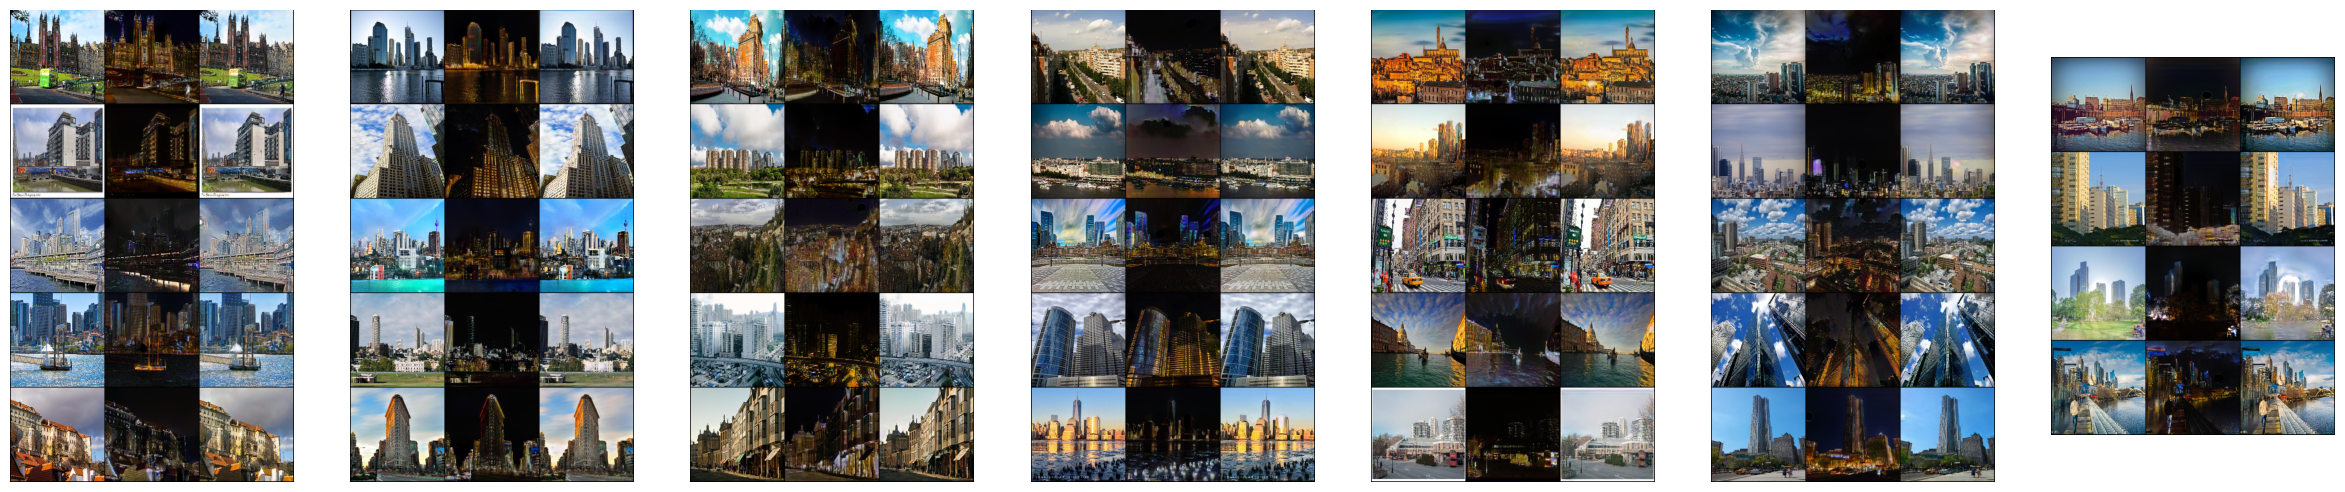

In [11]:
day_image_paths = []
for i in range(7): # 7 for day, 4 for night
  day_image_paths.append(data_path + f"/Results/V2/day_image_grid_{i}.png")

n_images = len(day_image_paths)

fig, axs = plt.subplots(1, n_images, figsize=(30, 15))

for i, image_path in enumerate(day_image_paths):
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

## Display Night to Day Test Images

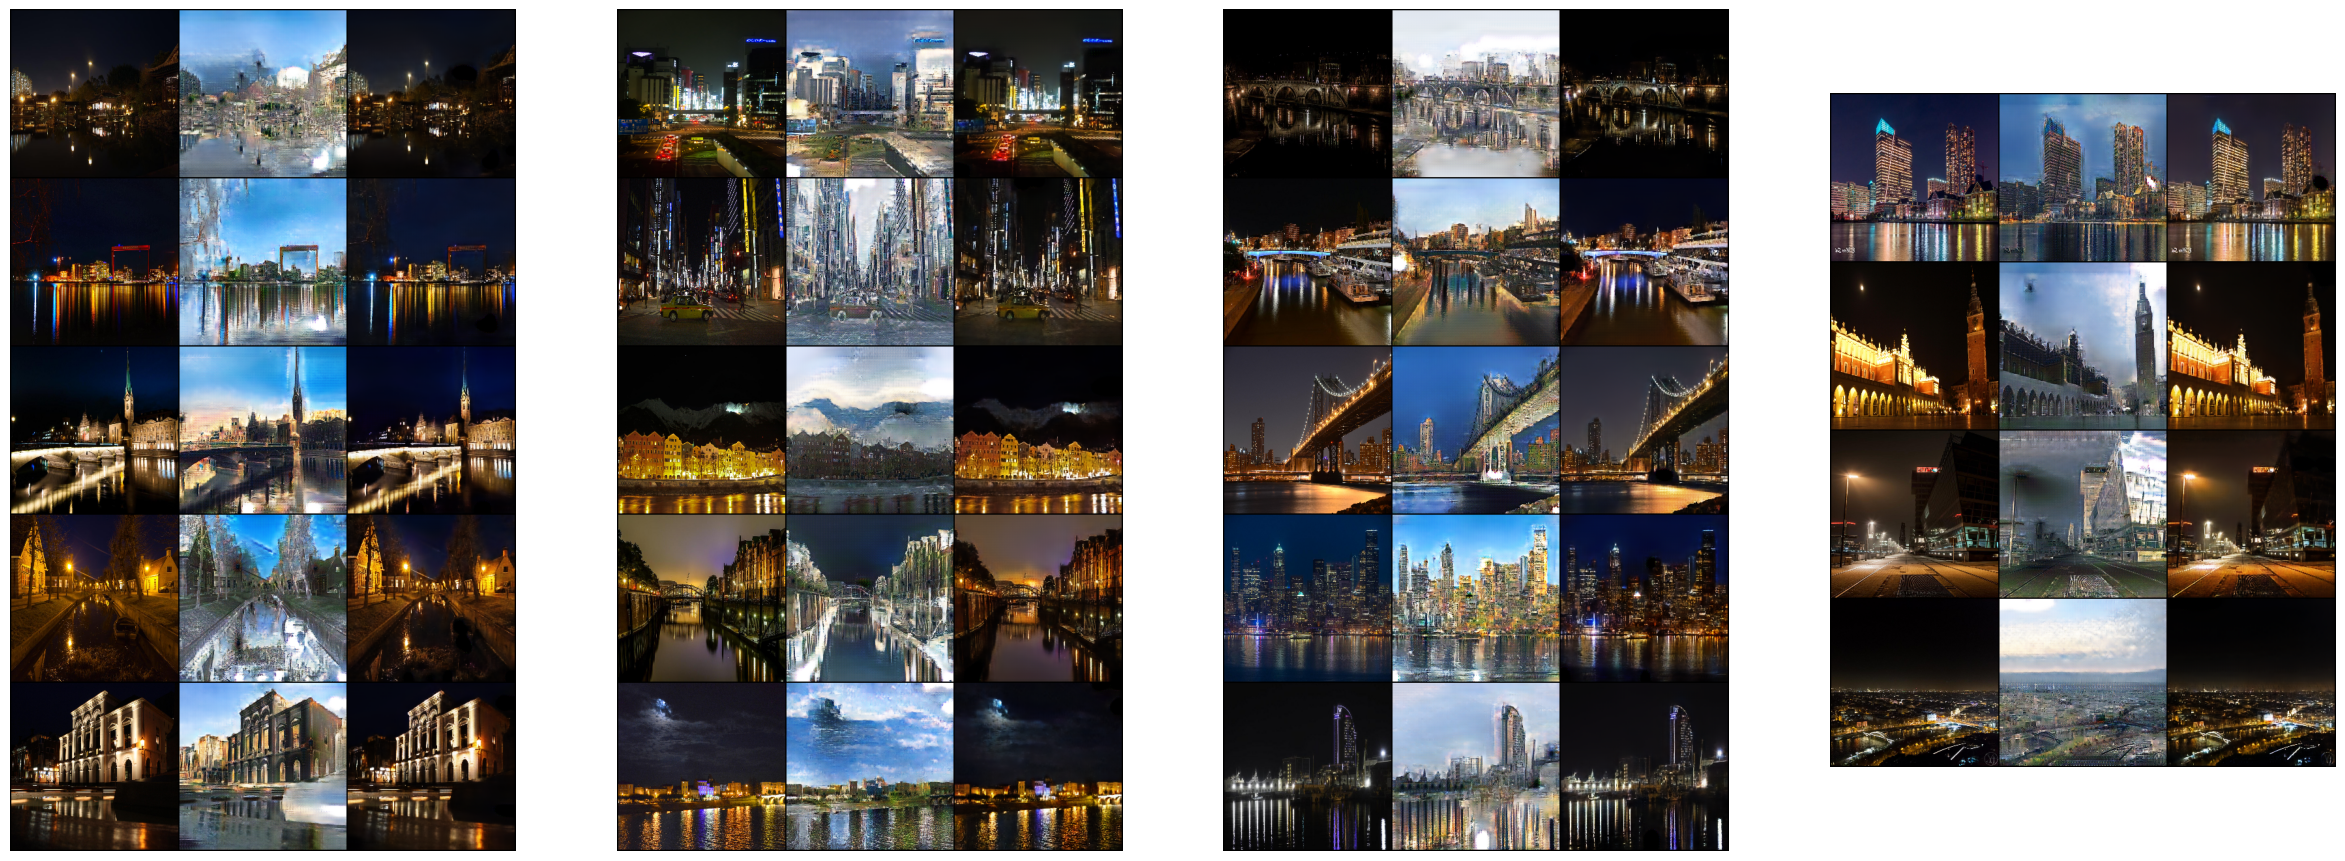

In [12]:
night_image_paths = []
for i in range(4): # 7 for day, 4 for night
  night_image_paths.append(data_path + f"/Results/V2/night_image_grid_{i}.png")

n_images = len(night_image_paths)

fig, axs = plt.subplots(1, n_images, figsize=(30, 15))

for i, image_path in enumerate(night_image_paths):
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()